> ![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)
_This is a [tutorial](https://github.com/SunnySuite/SunnyTutorials/tree/main/tutorials)
for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package,
which enables dynamical simulations of ordered and thermally disordered spins with dipole
and higher order moments._

In [1]:
# Welcome to a Sunny Tutorial on the Distorted Kagome Lattice System Na<sub>2</sub>IrO<sub>3</sub>

**Script**: Honeycomb Lattice Calculation <br>

In [2]:
#**Inspired by**:Na<sub>2</sub>IrO<sub>3</sub> SpinW tutorial (Sandor Toth https://spinw.org/tutorials/16tutorial). Parameters taken from Choi et al.

https://doi.org/10.1103/PhysRevLett.108.127204 <br>
**Authors**: Harry Lane <br>
**Date**: September 11, 2023  (Sunny 0.5.4) <br>
**Goal**: This script is to calculate the linear spin wave theory spectrum for Na<sub>2</sub>IrO<sub>3</sub> and compare with the results from SpinW.

This tutorial illustrates the calculation of the linear spin wave spectrum of Na<sub>2</sub>IrO<sub>3</sub> using the crystal structure and parameters found in <a href="https://doi.org/10.1103/PhysRevLett.108.127204 ">Choi et al., Phys. Rev. Lett. **108**, 127204</a>.

In [3]:
using Sunny, GLMakie, LinearAlgebra

Set up a `Crystal` using the parameters from
<a href="https://doi.org/10.1103/PhysRevLett.108.127204 ">Choi et al., Phys. Rev. Lett. **108**, 127204</a>.
In this tutorial we will first set up an ideal honeycomb model. We choose space group 1 to allow any arbitrary interaction.

The next step is to add interactions. The command `print_symmetry_table` shows all
symmetry-allowed interactions up to a cutoff distance.

Atom 1
Position [0.6667, 0.3333, 0], multiplicity 1
Allowed g-tensor: |   A  F+I  E-H |
                  | F-I    B  D+G |
                  | E+H  D-G    C |
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]
Allowed exchange matrix: |   A  F+I  E-H |
                         | F-I    B  D+G |
                         | E+H  D-G    C |
Allowed DM vector: [G H I]

Atom 2
Position [0.3333, 0.6667, 0], multiplicity 1
Allowed g-tensor: |   A  F+I  E-H |
                  | F-I    B  D+G |
                  | E+H  D-G    C |
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,

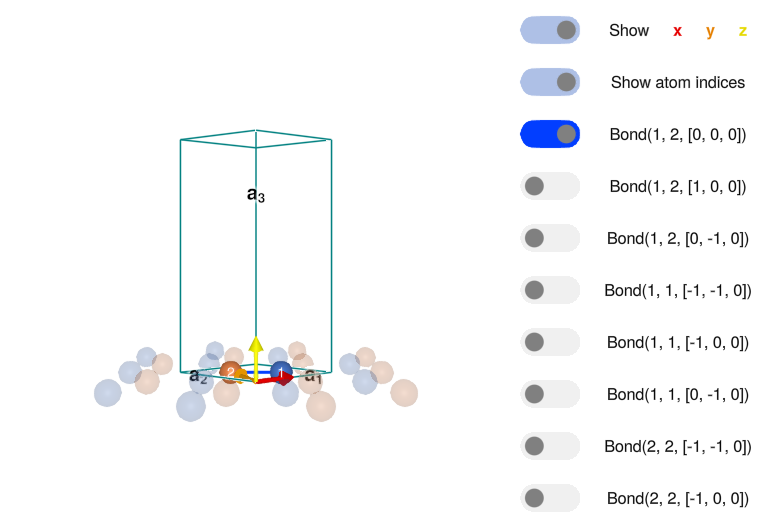

In [4]:
a=b=3
c=8
latvecs = lattice_vectors(a, b, c, 90, 90, 120)
positions = [[2/3,1/3,0],[1/3,2/3,0]]
crystal = Crystal(latvecs, positions,1;)

print_symmetry_table(crystal,8.0)

view_crystal(crystal,5.0)

We want to explore the Heisenberg-Kitaev model which gives rise to stripe order.

In [5]:
latsize = (2,2,1)
rn_seed = 5
K=-1.4
J = diagm([1,1,1])
Ja = J + diagm([K,0,0])
Jb = J + diagm([0,K,0])
Jc = J + diagm([0,0,K])
S=1/2
sys = System(crystal, latsize, [SpinInfo(1; S, g=2), SpinInfo(2; S, g=2)], :dipole; seed=rn_seed)
set_exchange!(sys, Ja, Bond(1, 2, [0,0,0]))
set_exchange!(sys, Jb, Bond(1, 2, [1,0,0]))
set_exchange!(sys, Jc, Bond(1, 2, [0,-1,0]))

function anneal!(sys,  integrator;  kTschedule, ndwell)
    nspins = prod(size(sys.dipoles));
    ensys  = zeros(length(kTschedule))
    for (i, kT) in enumerate(kTschedule)
        integrator.kT = kT
        for _ in 1:ndwell
            step!(sys, integrator)
        end
        ensys[i] = energy(sys)
    end
    return ensys/nspins
end

randomize_spins!(sys)
Δt = 0.01/abs(K)
λ = 0.1
langevin = Langevin(Δt; kT=0, λ)
kTs = [100 * 0.9^k for k in 0:200];
anneal!(sys,langevin;kTschedule=kTs,ndwell=1_000);
for _ ∈ 1:10_000
    step!(sys, langevin)
end
for i ∈ 1:20
    minimize_energy!(sys;maxiters=5_000)
end

Let's print the predominant wavevectors using `print_wrapped_intensities`.

In [6]:
for i ∈ 1:20
    minimize_energy!(sys;maxiters=5_000)
end
print_wrapped_intensities(sys)

Dominant wavevectors for spin sublattices:

    [0, 1/2, 0]            76.17% weight
    [1/2, 1/2, 0]          19.79%
    [1/2, 0, 0]             4.04%


We see that the wavevector is [0,1/2,0]. Let's try to reshape the unit cell.

┌ Warning: The `latsize` argument to `suggest_magnetic_supercell` is deprecated and unneeded.
└ @ Sunny ~/.julia/packages/Sunny/Z8eOT/src/MagneticOrdering.jl:75
Suggested magnetic supercell in multiples of lattice vectors:

    [1 0 0; 0 2 0; 0 0 1]

for wavevectors [[0, 1/2, 0]].


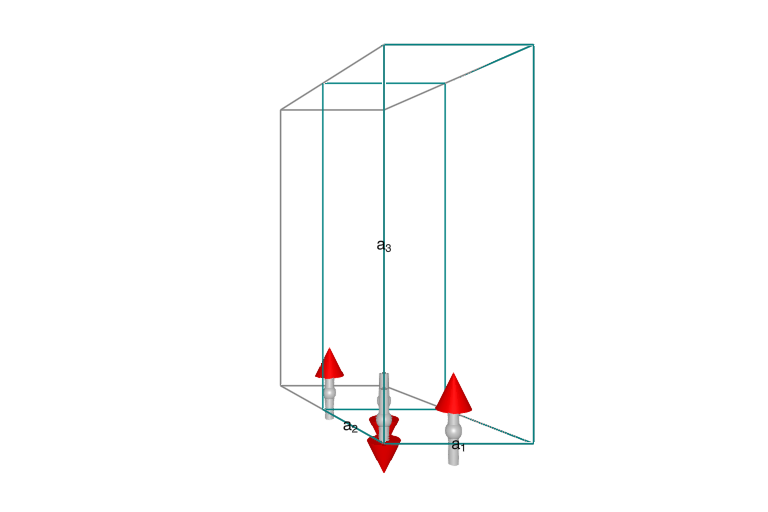

In [7]:
suggest_magnetic_supercell([[0, 1/2,0]], sys.latsize)
sys_min = reshape_supercell(sys, [1 0 0; 0 2 0; 0 0 1])
randomize_spins!(sys_min)
anneal!(sys_min,langevin;kTschedule=kTs,ndwell=20_000);
for _ ∈ 1:5_000
    step!(sys_min, langevin)
end
for i ∈ 1:10
    minimize_energy!(sys_min;maxiters=5_000)
end
plot_spins(sys_min; ghost_radius=3)

The next step is to build a `SpinWaveTheory` object.

In [8]:
swt = SpinWaveTheory(sys);

Before calculating the linear spin wave intensity, we must define a path in reciprocal space.
We plot along the direction a path in reciprocal space.

In [9]:
q_points = [[-1,0,0], [0,0,0], [0,1,0], [1,1,0], [1/2,1/2,0], [0,0,0]];
density = 50
path, xticks = reciprocal_space_path(crystal, q_points, density);

First we will plot the intensities using the delta function kernel.

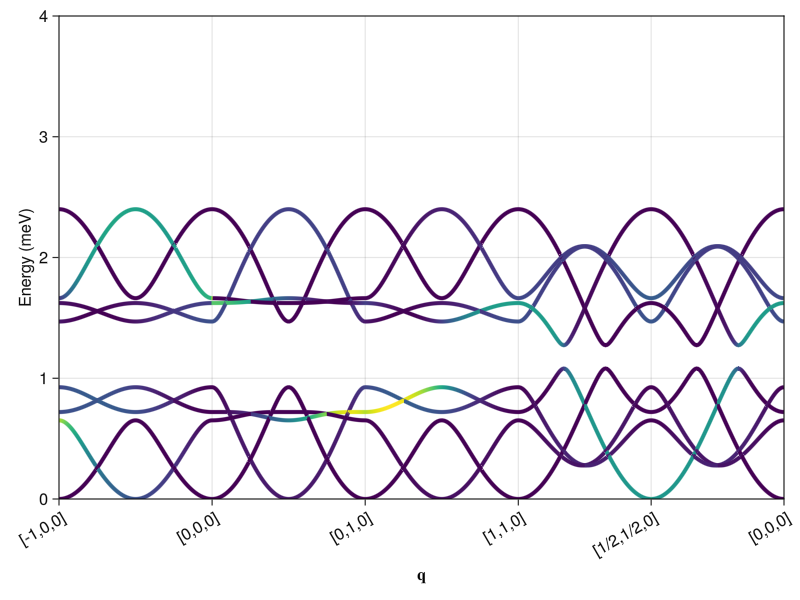

In [10]:
disp = dispersion(swt, path);
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);
fig = Figure()
ax = Axis(fig[1,1]; xlabel="𝐪", ylabel="Energy (meV)", xticks, xticklabelrotation=π/6)
ylims!(ax, 0.0, 4)
xlims!(ax, 1, size(disp, 1))
colorrange = extrema(intensity)
#colorrange = [0, 1.0]
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i]; color=intensity[:,i], colorrange,linewidth=4)
end
fig

We now create an intensity formula, specifying a Lorentzian linewidth, with a width of $0.15$ meV.

In [11]:
γ = 0.15 # width in meV
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))

Quantum Scattering Intensity Formula
At any (Q,ω), with S = S(Q,ωᵢ):

  Intensity(Q,ω) = ∑ᵢ Kernel(ω-ωᵢ) ∑_ij (I - Q⊗Q){i,j} S{i,j}
                                   
                                   (i,j = Sx,Sy,Sz)

Intensity(ω) reported


Finally we plot the broadened neutron scattering intensity along the path we defined above.

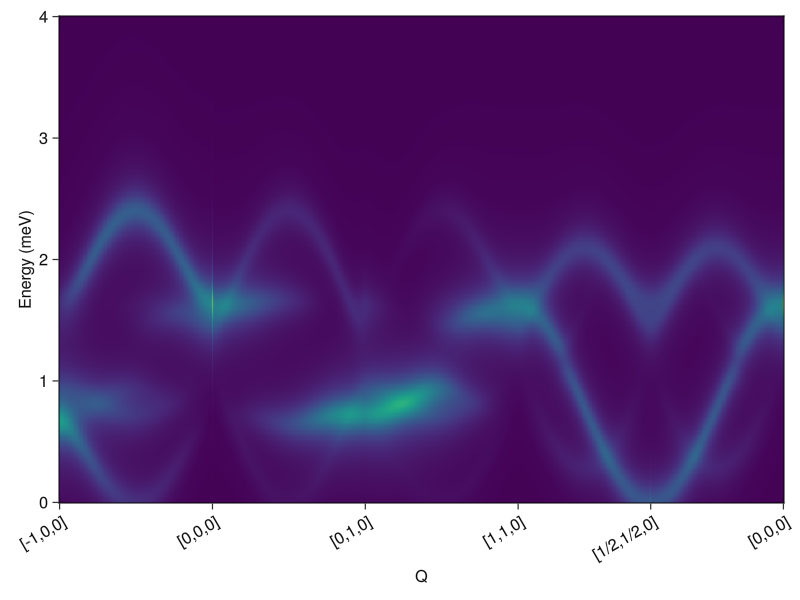

In [12]:
energies = collect(0:0.01:4)  # 0 < ω < 10 (meV).
is = intensities_broadened(swt, path, energies, broadened_formula);
colorrange = [0,1.0]
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Q", ylabel="Energy (meV)", xticks, xticklabelrotation=π/6)
heatmap!(ax, 1:size(is, 1), energies, is;colorrange)
fig

This is nice. Now let's try a real system: Na<sub>2</sub>IrO<sub>3</sub>. First define a new crystal.

In [13]:
a = 5.427
b = 9.395
c = 5.614
latvecs = lattice_vectors(a, b, c, 90, 109.037, 90)
positions = [[0,0,0],[1/2,0,1/2],[1/2,0.34,1/2],[1/2,0.167,0],[0.748,0.178,0.789],[0.711,0,0.204]]
types = ["Na","Na","Na","Ir","O","O"]
cryst_nairo = Crystal(latvecs, positions,12;setting = "b1",types)
crystal_nairo = subcrystal(cryst_nairo, "Ir")

[ Info: Atoms have been renumbered in subcrystal.


Crystal
HM symbol 'C 2/m = C 1 2/m 1' (12)
Lattice params a=5.427, b=9.395, c=5.614, α=90°, β=109°, γ=90°
Cell volume 270.6
Type 'Ir', Wyckoff 4g (point group '2'):
   1. [0.5, 0.167, 0]
   2. [0, 0.333, 0]
   3. [0, 0.667, 0]
   4. [0.5, 0.833, 0]


Let's look at the symmetry table and plot the crystal...

Atom 1
Type 'Ir', position [0.5, 0.167, 0], multiplicity 4
Allowed g-tensor: |   A    0  D-E |
                  |   0    B    0 |
                  | D+E    0    C |
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,0] + c₂*𝒪[2,1] + c₃*𝒪[2,2] +
    c₄*𝒪[4,0] + c₅*𝒪[4,1] + c₆*𝒪[4,2] + c₇*𝒪[4,3] + c₈*𝒪[4,4] +
    c₉*𝒪[6,0] + c₁₀*𝒪[6,1] + c₁₁*𝒪[6,2] + c₁₂*𝒪[6,3] + c₁₃*𝒪[6,4] + c₁₄*𝒪[6,5] + c₁₅*𝒪[6,6]
Allowed exchange matrix: |   A    0  D-E |
                         |   0    B    0 |
                         | D+E    0    C |
Allowed DM vector: [0 E 0]

Bond(1, 2, [0, 0, 0])
Distance 3.12975092218215, coordination 2
Connects 'Ir' at [0.5, 0.167, 0] to 'Ir' at [0, 0.333, 0]
Allowed exchange matrix: | A  F  E |
                         | F  B  D |
                         | E  D  C |

Bond(2, 3, [0, 0, 0])
Distance 3.13793, coordination 1
Connects 'Ir' at [0, 0.333, 0] to 'Ir' at [0, 0.667, 0]
Allowed exchange matrix: | A  0  D |
                         | 0  B  0 |
                    

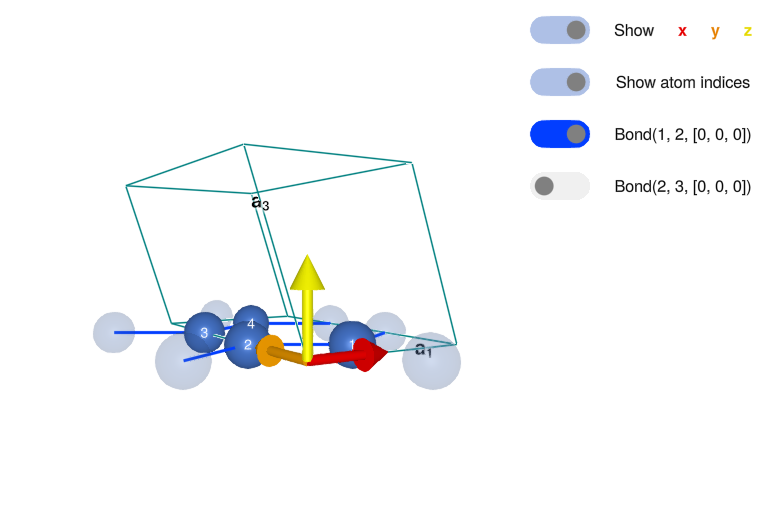

In [14]:
print_symmetry_table(crystal_nairo,8.0)
view_crystal(crystal_nairo,5.0)

Symmetry tells us that two of the three bonds are equivalent. This precludes a Kitaev model.
Suppose we think that our data really do suggest that the K-H model is the correct model and our structural
refinement is not correct. We might be tempted to set the space group to P1 (#1) as we did before. However
we want to use the symmetry operations to populate the spins. One option is to use the output of

In [15]:
#crystal to remove the symmetry.

crystal_nairo

Crystal
HM symbol 'C 2/m = C 1 2/m 1' (12)
Lattice params a=5.427, b=9.395, c=5.614, α=90°, β=109°, γ=90°
Cell volume 270.6
Type 'Ir', Wyckoff 4g (point group '2'):
   1. [0.5, 0.167, 0]
   2. [0, 0.333, 0]
   3. [0, 0.667, 0]
   4. [0.5, 0.833, 0]


Here we can read off the positions in the unit cell and build a new crystal with P1 symmetry.

Atom 1
Position [0.5, 0.167, 0], multiplicity 1
Allowed g-tensor: |   A  F+I  E-H |
                  | F-I    B  D+G |
                  | E+H  D-G    C |
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]
Allowed exchange matrix: |   A  F+I  E-H |
                         | F-I    B  D+G |
                         | E+H  D-G    C |
Allowed DM vector: [G H I]

Atom 2
Position [0, 0.333, 0], multiplicity 1
Allowed g-tensor: |   A  F+I  E-H |
                  | F-I    B  D+G |
                  | E+H  D-G    C |
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪

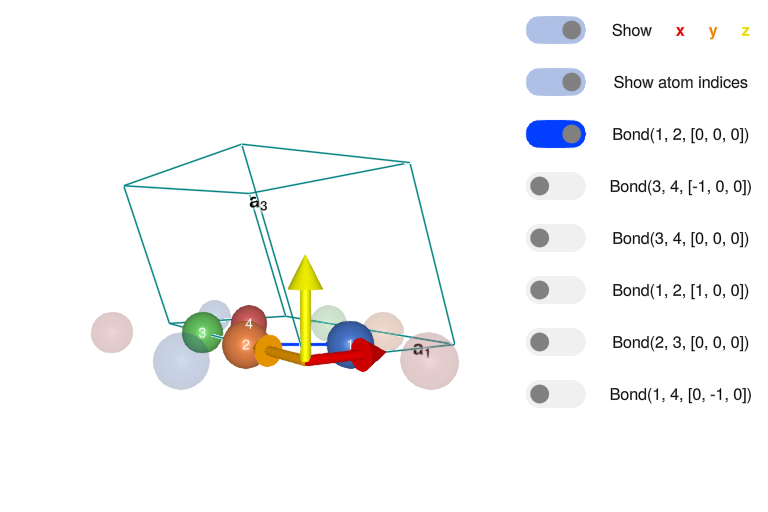

In [16]:
a = 5.427
b = 9.395
c = 5.614
latvecs = lattice_vectors(a, b, c, 90, 109.037, 90)
positions = [[0.5, 0.167, 0],[0, 0.333, 0],[0, 0.667, 0],[0.5, 0.833, 0]]
types = ["Ir","Ir","Ir","Ir"]
cryst_hack = Crystal(latvecs, positions,1)

print_symmetry_table(cryst_hack,8.0)
view_crystal(cryst_hack,5.0)

This is annoying because we don't want to have to define all the bonds in the unit cell.
One option is to add a small offset to two of the spins to explicitly break the symmetry.

Atom 1
Position [0.5, 0.167, 0.001], multiplicity 4
Allowed g-tensor: |   A  F+I  E-H |
                  | F-I    B  D+G |
                  | E+H  D-G    C |
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]
Allowed exchange matrix: |   A  F+I  E-H |
                         | F-I    B  D+G |
                         | E+H  D-G    C |
Allowed DM vector: [G H I]

Bond(1, 2, [0, 0, 0])
Distance 3.1281679315729, coordination 1
Connects [0.5, 0.167, 0.001] to [0, 0.333, 0]
Allowed exchange matrix: | A  F  E |
                         | F  B  D |
                         | E  D  C |

Bond(1, 2, [1, 0, 0])
Distance 3.13134317756309, coordina

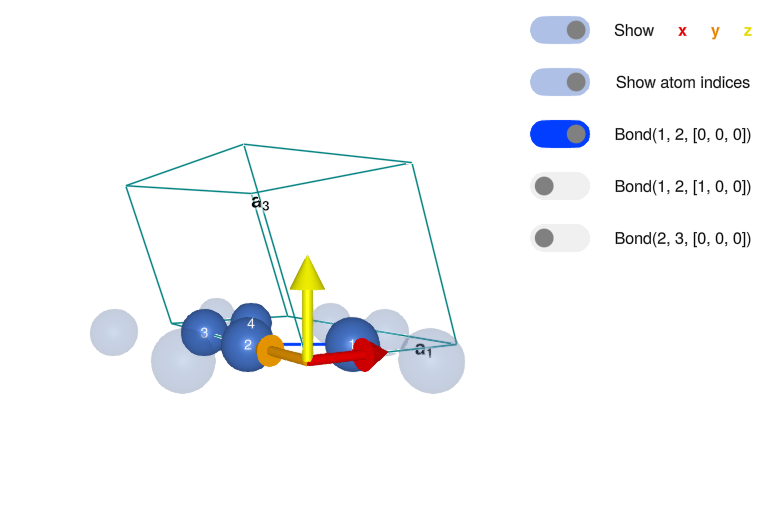

In [17]:
a = 5.427
b = 9.395
c = 5.614
latvecs = lattice_vectors(a, b, c, 90, 109.037, 90)
delta=1e-3
positions = [[0.5, 0.167, 0+delta],[0, 0.333, 0],[0, 0.667, 0],[0.5, 0.833, 0+delta]]
types = ["Ir","Ir","Ir","Ir"]
cryst_hack_2 = Crystal(latvecs, positions)

print_symmetry_table(cryst_hack_2,8.0)
view_crystal(cryst_hack_2,5.0)

Now let's proceed with calculating the spectrum.

Dominant wavevectors for spin sublattices:

    [1/2, 0, 0]            79.24% weight
    [0, 0, 0]              20.76%
┌ Warning: The `latsize` argument to `suggest_magnetic_supercell` is deprecated and unneeded.
└ @ Sunny ~/.julia/packages/Sunny/Z8eOT/src/MagneticOrdering.jl:75
Suggested magnetic supercell in multiples of lattice vectors:

    [2 0 0; 0 1 0; 0 0 1]

for wavevectors [[1/2, 0, 0]].


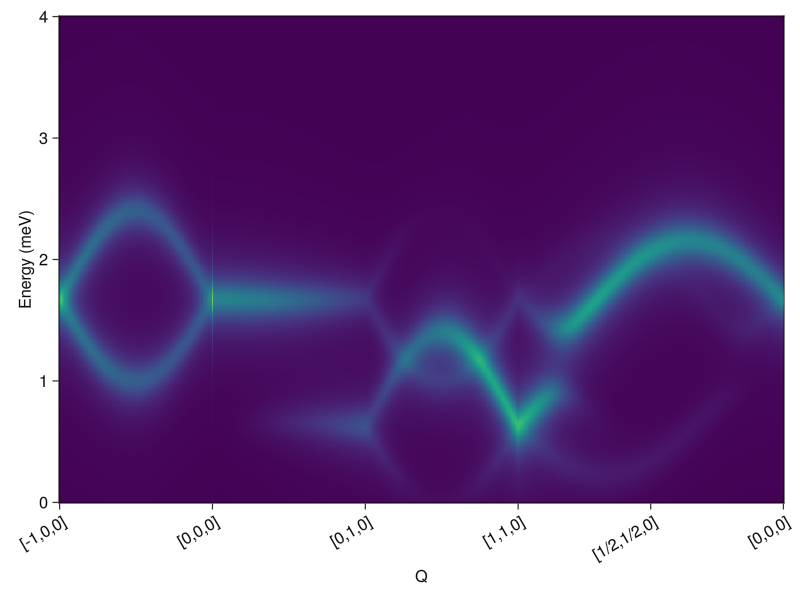

In [18]:
latsize = (2,1,1)
rn_seed = 5
K=-1.4
J = diagm([1,1,1])
Ja = J + diagm([K,0,0])
Jb = J + diagm([0,K,0])
Jc = J + diagm([0,0,K])
S=1/2
sys_hack = System(cryst_hack_2, latsize, [SpinInfo(1; S, g=2)], :dipole; seed=rn_seed)
set_exchange!(sys_hack, Ja, Bond(1, 2, [0,0,0]))
set_exchange!(sys_hack, Jb, Bond(1, 2, [1,0,0]))
set_exchange!(sys_hack, Jc, Bond(2, 3, [0,0,0]))

randomize_spins!(sys_hack)
anneal!(sys_hack,langevin;kTschedule=kTs,ndwell=50_000);
for _ ∈ 1:50_000
    step!(sys_hack, langevin)
end
for i ∈ 1:100
    minimize_energy!(sys;maxiters=5_000)
end
print_wrapped_intensities(sys_hack)
plot_spins(sys_hack)


suggest_magnetic_supercell([[1/2, 0,0]], sys_hack.latsize)
sys_hack_min = reshape_supercell(sys_hack, [1 0 0; 0 1 0; 0 0 1])
randomize_spins!(sys_hack_min)
anneal!(sys_hack_min,langevin;kTschedule=kTs,ndwell=50_000);
for _ ∈ 1:5_000
    step!(sys_hack_min, langevin)
end
for i ∈ 1:100
    minimize_energy!(sys_hack_min;maxiters=5_000)
end
plot_spins(sys_hack_min; ghost_radius=3)


swt = SpinWaveTheory(sys_hack_min,energy_ϵ=1e-6)
q_points = [[-1,0,0], [0,0,0], [0,1,0], [1,1,0], [1/2,1/2,0], [0,0,0]];
density = 50
path, xticks = reciprocal_space_path(crystal, q_points, density);
disp = dispersion(swt, path);
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);


fig = Figure()
ax = Axis(fig[1,1]; xlabel="𝐪", ylabel="Energy (meV)", xticks, xticklabelrotation=π/6)
ylims!(ax, 0.0, 4)
xlims!(ax, 1, size(disp, 1))
colorrange = extrema(intensity)
#colorrange = [0, 3.0]
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i]; color=intensity[:,i], colorrange,linewidth=4)
end
fig


γ = 0.15 # width in meV
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))
energies = collect(0:0.01:4)  # 0 < ω < 10 (meV).
is = intensities_broadened(swt, path, energies, broadened_formula);


fig = Figure()
colorrange=[0,1.0]
ax = Axis(fig[1,1]; xlabel="Q", ylabel="Energy (meV)", xticks, xticklabelrotation=π/6)
heatmap!(ax, 1:size(is, 1), energies, is;colorrange)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*